In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import seaborn as sns
import string
from string import punctuation
%matplotlib inline

In [208]:
df = pd.read_csv('train.csv')

In [247]:
df.head()

,label,tweet,length_tweet
0,0,@user when a father is dysfunctional and is s...,99
1,0,@user @user thanks for #lyft credit i can't us...,114
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,82
4,0,factsguide: society now #motivation,37


In [209]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [211]:
print('Percent of non racist/sexist sentiment: ',len(df[df['label'] == 0])/len(df))
print()
print('Percent of racist/sexist sentiment: ',len(df[df['label'] == 1])/len(df))

Percent of non racist/sexist sentiment:  0.9298542018647143

Percent of racist/sexist sentiment:  0.07014579813528565


In [212]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [213]:
df = df.drop('id',axis=1)
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [262]:
def length_tweet(text):
    '''This functin counts the length of text after 
    removing punctuation and whitespace from the text'''  
    text = ''.join([word for word in text if word not in punctuation])
    return len(text)

df['length_tweet'] = df['tweet'].apply(lambda x:length_tweet(x))

In [263]:
df.head()

,label,tweet,length_tweet
0,0,@user when a father is dysfunctional and is s...,99
1,0,@user @user thanks for #lyft credit i can't us...,114
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,82
4,0,factsguide: society now #motivation,37


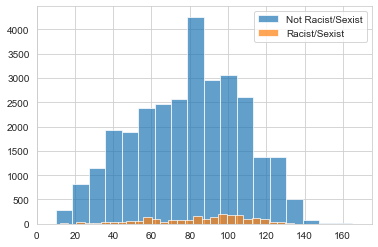

In [217]:
plt.hist(df[df['label']==0]['length_tweet'], bins = 30,alpha = 0.7, label = 'Not Racist/Sexist')
plt.hist(df[df['label']==1]['length_tweet'], bins = 30, alpha = 0.7, label = 'Racist/Sexist')
plt.xlim(0,175)
plt.legend()
plt.grid(True)
plt.show()

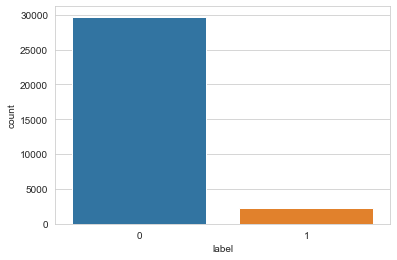

In [218]:
sns.countplot(x='label', data=df)
plt.show()

In [219]:
from sklearn.model_selection import train_test_split

In [220]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.3, random_state=42)

In [221]:
X_train

9635     summer timeð
 #summeriscoming #swimming #pic...
2447     dese niggas will show dese otha bitches on fb,...
16134    "when you are   you boost your immune system a...
18393    reading my manuscript and not wanting to stop....
4420                         baby says he hates me today  
                               ...                        
29802    #waltdisneyreso  should be ashamed of themselv...
5390      @user invited @user over for a catch up and i...
860      black professor makes assumptions about an ent...
15795    #lgbtqhatetrumppay is total #liberal trash. it...
23654    what makes people   is relative. we have our w...
Name: tweet, Length: 22373, dtype: object

In [228]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [265]:
tokenizer = Tokenizer(num_words=36000,oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

In [266]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

36446

In [267]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, 
                                maxlen=200,padding='post',truncating= 'post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, 
                                maxlen=200,padding='post',truncating= 'post')


In [ ]:
print(tokenize.word_index)

In [269]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout, SpatialDropout1D,GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.layers import Embedding

In [151]:
# Overfitted model
#model = Sequential()
#model.add(tf.keras.layers.Embedding(vocab_size, 64, input_length=200))
#model.add(SpatialDropout1D(0.25))
#model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5))
#model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5))
#model.add(Dropout(0.5))
#model.add(Dense(1,activation= 'sigmoid'))


In [270]:
model = Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 64, input_length=200))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(24, activation='relu'))
model.add(Dense(1,activation= 'sigmoid'))

In [271]:
model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 200, 64)           2332544   
_________________________________________________________________
global_average_pooling1d_9 ( (None, 64)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 25        
Total params: 2,334,129
Trainable params: 2,334,129
Non-trainable params: 0
_________________________________________________________________


In [272]:
from tensorflow.keras.callbacks import EarlyStopping

In [273]:
callback = EarlyStopping(monitor ='val_loss',min_delta = 0.001, patience=3, mode='min')

In [274]:
history = model.fit(training_padded,y_train,
    epochs=10,
    verbose=1,
    validation_data =(testing_padded, y_test), 
                    callbacks = [callback])

Epoch 1/10
700/700 [==============================] - 18s 25ms/step - loss: 0.3337 - accuracy: 0.9252 - val_loss: 0.2495 - val_accuracy: 0.9287
Epoch 2/10
700/700 [==============================] - 17s 24ms/step - loss: 0.2500 - accuracy: 0.9282 - val_loss: 0.2329 - val_accuracy: 0.9287
Epoch 3/10
700/700 [==============================] - 17s 25ms/step - loss: 0.2206 - accuracy: 0.9294 - val_loss: 0.1823 - val_accuracy: 0.9286
Epoch 4/10
700/700 [==============================] - 17s 25ms/step - loss: 0.1534 - accuracy: 0.9396 - val_loss: 0.1541 - val_accuracy: 0.9438
Epoch 5/10
700/700 [==============================] - 18s 26ms/step - loss: 0.1027 - accuracy: 0.9642 - val_loss: 0.1387 - val_accuracy: 0.9525
Epoch 6/10
700/700 [==============================] - 17s 25ms/step - loss: 0.0816 - accuracy: 0.9727 - val_loss: 0.1388 - val_accuracy: 0.9555
Epoch 7/10
700/700 [==============================] - 17s 25ms/step - loss: 0.0694 - accuracy: 0.9766 - val_loss: 0.1504 - val_accuracy:

In [235]:
#history.history

In [275]:
scores = pd.DataFrame(history.history,columns = ['loss','accuracy','val_loss','val_accuracy'])
scores

,loss,accuracy,val_loss,val_accuracy
0,0.273614,0.929647,0.249523,0.928668
1,0.241100,0.930362,0.232904,0.928668
2,0.204731,0.930362,0.182301,0.928564
3,0.142600,0.945068,0.154080,0.943790
4,0.101507,0.963796,0.138712,0.952550
5,0.080481,0.973852,0.138811,0.955470
6,0.068492,0.976981,0.150425,0.955366
7,0.057275,0.980423,0.154617,0.956408


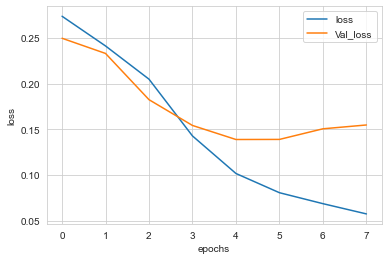

In [276]:
sns.set_style('whitegrid')
plt.plot(scores['loss'], label = 'loss')
plt.plot(scores['val_loss'], label= 'Val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

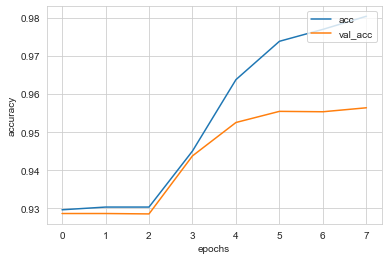

In [277]:
plt.plot(scores['accuracy'], label = 'acc')
plt.plot(scores['val_accuracy'], label= 'val_acc')
plt.legend(loc= 'upper right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [278]:
from sklearn.metrics import classification_report, confusion_matrix

In [279]:
y_predict = model.predict(testing_padded).round()
y_predict

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [280]:
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      9237
         1.0       0.45      0.88      0.60       352

    accuracy                           0.96      9589
   macro avg       0.72      0.92      0.79      9589
weighted avg       0.98      0.96      0.96      9589



In [281]:
print(confusion_matrix(y_predict, y_test))

[[8862  375]
 [  43  309]]
